In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# Sci-kit Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

# NN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Conv2D, MaxPooling2D

In [2]:
# Load file
df = pd.read_csv("all_merged_sw.csv",
                 usecols=['post_id', 'date', 'sw_1_num_comments', 'sw_1_score', 'sw_1_total_awards',
                          'author_commentkarma', 'sw_1_compound_score', 'sw_1_author_trust', 'trustworthy',
                          'author_trust', 'author_id', 'author_name',
                          'ticker', 'post_type', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
                          'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X', 
                          'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
                          'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
                          'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
                          'adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
                          'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
                          'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
                          'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y',
                          'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
                          'adjclose_21_Y', 'y_slope'])

# Create trend column
df['trend'] = df['y_slope'].apply(lambda x : 1 if x >= 0.5 else (-1 if x <= -0.5 else 0))

# Apply trust filter
df = df[(df["sw_1_author_trust"] >= 0.8) & (df["trustworthy"] == 1)]

# Reset index
df.reset_index(drop=True, inplace=True)

df

,post_id,date,author_commentkarma,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,...,adjclose_21_Y,trustworthy,author_trust,sw_1_num_comments,sw_1_score,sw_1_total_awards,sw_1_compound_score,sw_1_author_trust,y_slope,trend
0,ed2x6fn,2019-01-02,712.0,rw1ynq0,martimook,CPSI,comment,25.979984,25.950769,25.882610,...,25.551525,1,0.800000,2.0,61.0,0.0,0.0516,0.800000,0.000608,0
1,ed5w9cb,2019-01-03,228.0,5qcvv4b,daytradekingpin,BHF,comment,40.709999,40.259998,40.040001,...,37.430000,1,1.000000,0.0,1.0,0.0,0.3612,1.000000,0.284985,0
2,ed458zx,2019-01-03,13431.0,gsb35,Physiologist21,CGC,comment,33.330002,33.549999,33.180000,...,48.880001,1,0.888889,0.0,3.0,0.0,0.5927,0.888889,1.090985,1
3,ed7nipz,2019-01-04,3.0,4jd5aav,fz27fz,BPY,comment,14.357750,14.423088,14.292412,...,15.166289,1,1.000000,0.0,-1.0,0.0,0.4404,1.000000,0.043826,0
4,ed7nipz,2019-01-04,3.0,4jd5aav,fz27fz,PS,comment,25.650000,24.090000,24.040001,...,31.270000,1,1.000000,0.0,-1.0,0.0,0.4404,1.000000,0.231872,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,ghms232,2020-12-31,66817.0,5dmrn99z,Experienced_AP,PBPB,comment,4.720000,4.700000,4.660000,...,5.430000,1,1.000000,0.0,1.0,0.0,0.1027,1.000000,0.022985,0
1975,ghkio9m,2020-12-31,75.0,8nh43gr6,Jelly_Sir,ANAB,comment,25.790001,25.790001,24.680000,...,25.940001,1,1.000000,0.0,1.0,0.0,0.4404,1.000000,0.045767,0
1976,ghkio9m,2020-12-31,75.0,8nh43gr6,Jelly_Sir,AGNC,comment,14.938175,15.221688,15.182583,...,15.774995,1,1.000000,0.0,1.0,0.0,0.4404,1.000000,0.040416,0
1977,ghm5b2k,2020-12-31,47.0,7woh0cgu,mobilazy,ETNB,comment,27.010000,27.280001,27.040001,...,21.360001,1,1.000000,0.0,1.0,0.0,0.4404,1.000000,-0.134000,0


In [3]:
# Print the colum names
df.columns.values

array(['post_id', 'date', 'author_commentkarma', 'author_id',
       'author_name', 'ticker', 'post_type', 'adjclose_20_X',
       'adjclose_19_X', 'adjclose_18_X', 'adjclose_17_X', 'adjclose_16_X',
       'adjclose_15_X', 'adjclose_14_X', 'adjclose_13_X', 'adjclose_12_X',
       'adjclose_11_X', 'adjclose_10_X', 'adjclose_9_X', 'adjclose_8_X',
       'adjclose_7_X', 'adjclose_6_X', 'adjclose_5_X', 'adjclose_4_X',
       'adjclose_3_X', 'adjclose_2_X', 'adjclose_1_X', 'adjclose_2_Y',
       'adjclose_3_Y', 'adjclose_4_Y', 'adjclose_5_Y', 'adjclose_6_Y',
       'adjclose_7_Y', 'adjclose_8_Y', 'adjclose_9_Y', 'adjclose_10_Y',
       'adjclose_11_Y', 'adjclose_12_Y', 'adjclose_13_Y', 'adjclose_14_Y',
       'adjclose_15_Y', 'adjclose_16_Y', 'adjclose_17_Y', 'adjclose_18_Y',
       'adjclose_19_Y', 'adjclose_20_Y', 'adjclose_21_Y', 'trustworthy',
       'author_trust', 'sw_1_num_comments', 'sw_1_score',
       'sw_1_total_awards', 'sw_1_compound_score', 'sw_1_author_trust',
       'y_slope

In [4]:
"""Find when to buy and sell"""

# Columns of interest
tempDF = df[['adjclose_1_X', 'adjclose_2_Y', 'adjclose_3_Y', 'adjclose_4_Y',
             'adjclose_5_Y', 'adjclose_6_Y', 'adjclose_7_Y', 'adjclose_8_Y',
             'adjclose_9_Y', 'adjclose_10_Y', 'adjclose_11_Y', 'adjclose_12_Y',
             'adjclose_13_Y', 'adjclose_14_Y', 'adjclose_15_Y', 'adjclose_16_Y', 
             'adjclose_17_Y', 'adjclose_18_Y', 'adjclose_19_Y', 'adjclose_20_Y',
             'adjclose_21_Y']]

# Divide each row by row minimum
df_buy = tempDF.div(tempDF.min(axis=1), axis=0)

# Divide each row by row maximum
df_sell = tempDF.div(tempDF.max(axis=1), axis=0)

# Empty list to store each row for buy
buy_rows = []

# Empty list to store each row for sell
sell_rows = []

# For each row
for i in range(len(tempDF.index)):
    
    """Buy"""
    # Convert the pandas row to a list
    buy_row = df_buy.iloc[i].tolist()
    
    # Filter the list for all elements starting from when the index where the value 1.0 is
    filt_row = buy_row[buy_row.index(1.0):]
    
    # If filter row contains a value >= 1.07
    if any(x >= 1.07 for x in filt_row):
        
        # All values not equal to 1 are assigned 0
        buy_row = [(lambda i: 0 if i != 1.0 else i)(i) for i in buy_row]
    
    # Else, don't buy
    else:
        # Create row of all 0s
        buy_row = [0] * len(buy_row)
    
    # Append the row as data frame to buy_rows
    buy_rows.append(buy_row)
    
    """Sell"""
    # Convert the pandas row to a list
    sell_row = df_sell.iloc[i].tolist()
    
    # If the percent change from maximum to date of post is >= 7%
    if ((1-sell_row[0])/sell_row[0] >= 0.07):
        
        # All values not equal to 1 are assigned 0
        sell_row = [(lambda i: 0 if i != 1.0 else i)(i) for i in sell_row]
    
    # else, don't sell
    else:
        # Create row of all 0s
        sell_row = [0] * len(sell_row)
    
    # Append the row as data frame to buy_rows
    sell_rows.append(sell_row)

# Column names for df_buy
cols = ['buy_1_X', 'buy_2_Y', 'buy_3_Y', 'buy_4_Y', 'buy_5_Y', 'buy_6_Y', 'buy_7_Y',
        'buy_8_Y', 'buy_9_Y', 'buy_10_Y', 'buy_11_Y', 'buy_12_Y', 'buy_13_Y', 'buy_14_Y', 
        'buy_15_Y', 'buy_16_Y', 'buy_17_Y', 'buy_18_Y', 'buy_19_Y', 'buy_20_Y', 'buy_21_Y']

# Concatenate buy_rows into one data frame
df_buy = pd.DataFrame(buy_rows, columns=cols)

# Rename the columns
cols = ['sell_1_X', 'sell_2_Y', 'sell_3_Y', 'sell_4_Y', 'sell_5_Y', 'sell_6_Y',
        'sell_7_Y', 'sell_8_Y', 'sell_9_Y', 'sell_10_Y', 'sell_11_Y', 'sell_12_Y',
        'sell_13_Y', 'sell_14_Y', 'sell_15_Y', 'sell_16_Y', 'sell_17_Y', 'sell_18_Y',
        'sell_19_Y', 'sell_20_Y', 'sell_21_Y']

# Concatenate buy_rows into one data frame
df_sell = pd.DataFrame(sell_rows, columns=cols)

# Display
display(df_buy.head())
display(df_sell.head())

# Concatenate df, df_buy, and df_sell
df = pd.concat([df, df_buy, df_sell], axis=1)

# Display
display(df.head())

# Count number of 0s in each buy column
for i in df_buy.columns:
    print("The number of 0s in", i, "is :", (df_buy[i] == 0).sum())

# Count number of 0s in each sell column
for i in df_sell.columns:
    print("The number of 0s in", i, "is :", (df_sell[i] == 0).sum())

,buy_1_X,buy_2_Y,buy_3_Y,buy_4_Y,buy_5_Y,buy_6_Y,buy_7_Y,buy_8_Y,buy_9_Y,buy_10_Y,...,buy_12_Y,buy_13_Y,buy_14_Y,buy_15_Y,buy_16_Y,buy_17_Y,buy_18_Y,buy_19_Y,buy_20_Y,buy_21_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,sell_1_X,sell_2_Y,sell_3_Y,sell_4_Y,sell_5_Y,sell_6_Y,sell_7_Y,sell_8_Y,sell_9_Y,sell_10_Y,...,sell_12_Y,sell_13_Y,sell_14_Y,sell_15_Y,sell_16_Y,sell_17_Y,sell_18_Y,sell_19_Y,sell_20_Y,sell_21_Y
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,post_id,date,author_commentkarma,author_id,author_name,ticker,post_type,adjclose_20_X,adjclose_19_X,adjclose_18_X,...,sell_12_Y,sell_13_Y,sell_14_Y,sell_15_Y,sell_16_Y,sell_17_Y,sell_18_Y,sell_19_Y,sell_20_Y,sell_21_Y
0,ed2x6fn,2019-01-02,712.0,rw1ynq0,martimook,CPSI,comment,25.979984,25.950769,25.882610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ed5w9cb,2019-01-03,228.0,5qcvv4b,daytradekingpin,BHF,comment,40.709999,40.259998,40.040001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ed458zx,2019-01-03,13431.0,gsb35,Physiologist21,CGC,comment,33.330002,33.549999,33.180000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,ed7nipz,2019-01-04,3.0,4jd5aav,fz27fz,BPY,comment,14.357750,14.423088,14.292412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ed7nipz,2019-01-04,3.0,4jd5aav,fz27fz,PS,comment,25.650000,24.090000,24.040001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The number of 0s in buy_1_X is : 1126
The number of 0s in buy_2_Y is : 1868
The number of 0s in buy_3_Y is : 1893
The number of 0s in buy_4_Y is : 1907
The number of 0s in buy_5_Y is : 1929
The number of 0s in buy_6_Y is : 1946
The number of 0s in buy_7_Y is : 1945
The number of 0s in buy_8_Y is : 1938
The number of 0s in buy_9_Y is : 1949
The number of 0s in buy_10_Y is : 1941
The number of 0s in buy_11_Y is : 1948
The number of 0s in buy_12_Y is : 1946
The number of 0s in buy_13_Y is : 1943
The number of 0s in buy_14_Y is : 1950
The number of 0s in buy_15_Y is : 1956
The number of 0s in buy_16_Y is : 1950
The number of 0s in buy_17_Y is : 1956
The number of 0s in buy_18_Y is : 1952
The number of 0s in buy_19_Y is : 1964
The number of 0s in buy_20_Y is : 1969
The number of 0s in buy_21_Y is : 1977
The number of 0s in sell_1_X is : 1979
The number of 0s in sell_2_Y is : 1865
The number of 0s in sell_3_Y is : 1915
The number of 0s in sell_4_Y is : 1927
The number of 0s in sell_5_Y is : 

In [5]:
# Get the X-variable columns
df_X = df[['sw_1_num_comments', 'sw_1_score', 'sw_1_total_awards', 'author_commentkarma',
           'sw_1_compound_score', 'adjclose_20_X', 'adjclose_19_X', 'adjclose_18_X',
           'adjclose_17_X', 'adjclose_16_X', 'adjclose_15_X', 'adjclose_14_X',
           'adjclose_13_X', 'adjclose_12_X', 'adjclose_11_X', 'adjclose_10_X',
           'adjclose_9_X', 'adjclose_8_X', 'adjclose_7_X', 'adjclose_6_X',
           'adjclose_5_X', 'adjclose_4_X', 'adjclose_3_X', 'adjclose_2_X',
           'adjclose_1_X']].to_numpy()

# Get the Y-variable columns
df_Y = df[['trend', 'buy_1_X', 'buy_2_Y', 'buy_3_Y', 'buy_4_Y', 'buy_5_Y', 'buy_6_Y', 'buy_7_Y',
           'buy_8_Y', 'buy_9_Y', 'buy_10_Y', 'buy_11_Y', 'buy_12_Y', 'buy_13_Y', 'buy_14_Y',
           'buy_15_Y', 'buy_16_Y', 'buy_17_Y', 'buy_18_Y', 'buy_19_Y', 'buy_20_Y', 'buy_21_Y',
           'sell_1_X', 'sell_2_Y', 'sell_3_Y', 'sell_4_Y', 'sell_5_Y', 'sell_6_Y', 'sell_7_Y',
           'sell_8_Y', 'sell_9_Y', 'sell_10_Y', 'sell_11_Y', 'sell_12_Y', 'sell_13_Y', 'sell_14_Y',
           'sell_15_Y', 'sell_16_Y', 'sell_17_Y', 'sell_18_Y', 'sell_19_Y', 'sell_20_Y', 'sell_21_Y']].to_numpy()

# Clear up memory
del df
del tempDF
del cols
del df_buy
del df_sell
gc.collect()

# Get 80% of the data by date
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2,
                                                    shuffle=False)

# Print
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[ 2.         61.          0.         ... 27.21815872 26.13175964
  26.09296036]
 [ 0.          1.          0.         ... 43.18999863 44.02999878
  42.61000061]
 [ 0.          3.          0.         ... 46.06999969 42.59000015
  40.09000015]
 ...
 [ 1.          2.          0.         ...  3.18499994  3.6500001
   3.9000001 ]
 [ 0.          2.          0.         ... 13.52000046 13.22999954
  13.55000019]
 [ 1.          1.          0.         ...  3.52999997  3.52999997
   3.49000001]]
[[ 1.          1.          0.         ... 60.33877563 60.80467224
  60.09095764]
 [ 1.          1.          0.         ... 17.87000084 18.04000092
  17.79999924]
 [ 2.          2.          0.         ... 19.84000015 19.95999908
  19.62000084]
 ...
 [ 0.          1.          0.         ... 13.64977264 13.52365589
  13.57216167]
 [ 0.          1.          0.         ... 24.92000008 23.57999992
  23.29000092]
 [ 0.          1.          0.         ... 89.30999756 82.69000244
  82.31999969]]
[[0. 0. 0. ... 0.

In [6]:
# Normalize data
scaler = MinMaxScaler()

print(scaler.fit(X_train))
xtrain_scale=scaler.transform(X_train)

print(scaler.fit(X_test))
X_test=scaler.transform(X_test)

# Convert from float to int
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Set input and output dimensions
indim = X_train.shape[1]
outdim = y_train.shape[1]

# Initialize Feed-Forward Neural Network
model = Sequential()

# Create NN structure
# Input layer
model.add(Dense(indim+1, input_dim=indim, activation="relu"))

# Hidden layer with ~sqrt(X_train.shape[0] = sqrt(36578))
model.add(Dense(X_train.shape[0]**0.5, activation="relu"))

# Output layer
model.add(Dense(outdim))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(xtrain_scale, y_train, epochs=10, batch_size=20, verbose=0)

# Predict
ypred = model.predict(X_test)

MinMaxScaler()
MinMaxScaler()


In [7]:
# Evaluate Accuracy Score

# Convert y_test and ypred to type ints
y_test = y_test.astype(int)
ypred = ypred.astype(int)

# Empty list to store accuracy scores
acc_score = []

# Empty list to store f1 scores
f1 = []

# For each column in ypred, calculate accuracy score
for i in range(ypred.shape[1]):
    
    acc_score.append(accuracy_score(y_test[:, i], ypred[:, i]))
    f1.append(f1_score(y_test[:, i], ypred[:, i], average='weighted', zero_division=0))

# For each value in accuracy
for j in range(len(acc_score)):

    if j == 0:
        print("The accuracy score for trend =", acc_score[j])
    elif j == 1:
        print("The accuracy score for buy_{}_X =".format(j), acc_score[j])
    elif 1 < j < 22:
        print("The accuracy score for buy_{}_Y =".format(j), acc_score[j])
    elif j == 22:
        print("The accuracy score for sell_{}_X =".format(j-21), acc_score[j])
    else:
        print("The accuracy score for sell_{}_Y =".format(j-21), acc_score[j])

print("\n")

# For each value in f1
for k in range(len(f1)):

    if k == 0:
        print("The f1 score for trend =", f1[k])
    elif k == 1:
        print("The f1 score for buy_{}_X =".format(k), f1[k])
    elif 1 < k < 22:
        print("The f1 score for buy_{}_Y =".format(k), f1[k])
    elif k == 22:
        print("The f1 score for sell_{}_X =".format(k-21), f1[k])
    else:
        print("The f1 score for sell_{}_Y =".format(k-21), f1[k])

# Print overall model average
print("\nThe overall accuracy score for buy is:", sum(acc_score[1:22])/len(acc_score[1:22]))
print("The overall f1 score for buy is:", sum(f1[1:22])/len(f1[1:22]))
print("The overall accuracy score for sell is:", sum(acc_score[22:])/len(acc_score[22:]))
print("The overall f1 score for sell is:", sum(f1[22:])/len(f1[22:]))

The accuracy score for trend = 0.9116161616161617
The accuracy score for buy_1_X = 0.3787878787878788
The accuracy score for buy_2_Y = 0.952020202020202
The accuracy score for buy_3_Y = 0.9570707070707071
The accuracy score for buy_4_Y = 0.9747474747474747
The accuracy score for buy_5_Y = 0.9747474747474747
The accuracy score for buy_6_Y = 0.9873737373737373
The accuracy score for buy_7_Y = 0.9848484848484849
The accuracy score for buy_8_Y = 0.9848484848484849
The accuracy score for buy_9_Y = 0.9873737373737373
The accuracy score for buy_10_Y = 0.9848484848484849
The accuracy score for buy_11_Y = 0.9823232323232324
The accuracy score for buy_12_Y = 0.9873737373737373
The accuracy score for buy_13_Y = 0.9848484848484849
The accuracy score for buy_14_Y = 0.9873737373737373
The accuracy score for buy_15_Y = 0.9949494949494949
The accuracy score for buy_16_Y = 0.98989898989899
The accuracy score for buy_17_Y = 0.9924242424242424
The accuracy score for buy_18_Y = 0.98989898989899
The accura

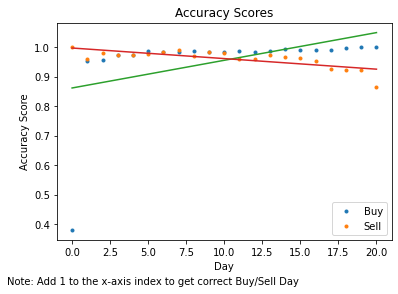

In [8]:
# Plot the Accuracy Scores
x = np.arange(21)
y = acc_score[1:22]
y2 = acc_score[22:]

# Fit with polyfit
b, m = polyfit(x, y, 1)
b2, m2 = polyfit(x, y2, 1)

# Add title and axis names
plt.title('Accuracy Scores')
plt.xlabel('Day')
plt.ylabel('Accuracy Score')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 1 to the x-axis index to get correct Buy/Sell Day',
            horizontalalignment='left')

plt.plot(x, y, '.', label="Buy")
plt.plot(x, y2, '.', label="Sell")
plt.plot(x, m*x+b, '-')
plt.plot(x, m2*x+b2, '-')
plt.legend()
plt.show()

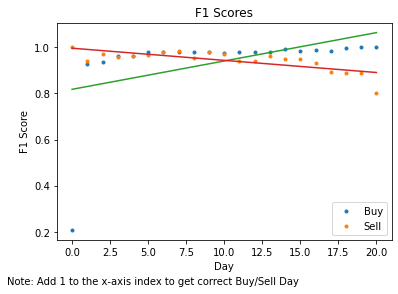

In [9]:
# Plot the F1 Scores
x = np.arange(21)
y = f1[1:22]
y2 = f1[22:]

# Fit with polyfit
b, m = polyfit(x, y, 1)
b2, m2 = polyfit(x, y2, 1)

# Add title and axis names
plt.title('F1 Scores')
plt.xlabel('Day')
plt.ylabel('F1 Score')

# Add a footnote below and to the left side of the chart
plt.figtext(0.01, -0.03,
            'Note: Add 1 to the x-axis index to get correct Buy/Sell Day',
            horizontalalignment='left')

plt.plot(x, y, '.', label="Buy")
plt.plot(x, y2, '.', label="Sell")
plt.plot(x, m*x+b, '-')
plt.plot(x, m2*x+b2, '-')
plt.legend()
plt.show()